## Library Installation

In [ ]:
%pip install pyspark
%pip install mlflow
%pip install tensorflow
%pip install py4j

###  Libraries importing

In [1]:

#import DadosIO as Db
#import Function as ut_f

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mlflow
import mlflow.keras

from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark.sql.window import Window

### Model Initialization

In [18]:


'''df = ut_f.filtro_ultimas_particoes(spark, 
                                           'sandbox.silver_acoes_disney', 
                                           nm_particao='dt_carga', 
                                           qtd_dias_filtro=3, 
                                           delta=True)
'''

# Initialize a Spark session
spark = SparkSession.builder.appName("LSTMStockPredictor").getOrCreate()

df = pd.read_csv("out.csv")  

# Create a Spark DataFrame from Pandas DataFrame
df = spark.createDataFrame(pd.DataFrame(df['Close'], columns=['Close']).reset_index())

#check first row
first_row = df.first()

if type(first_row['Close']) == str:
    df = df.filter(df.Close != first_row["Close"])

print(df.head(3))


[Row(index=1, Close='NaN'), Row(index=2, Close='102.16000366210938'), Row(index=3, Close='99.5')]


### Preprocess

In [19]:
closing_prices = df.select("Close").rdd.flatMap(lambda x: x).collect()

closing_prices = [
    float(price.lower()) for price in closing_prices if price.lower() not in [None, '', 'nan'] and not pd.isna(price)
]

closing_prices = np.array(closing_prices).reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Create sequences for training
sequence_length = 60
X_train, y_train = [], []

for i in range(sequence_length, len(scaled_data)):
    X_train.append(scaled_data[i-sequence_length:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Build the LSTM model

c:\Users\eng3\Documents\projetos\fiap\tech_challenger_4\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - loss: 0.0973
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0204
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0166
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0131
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0101


2024/11/09 14:37:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/09 14:38:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


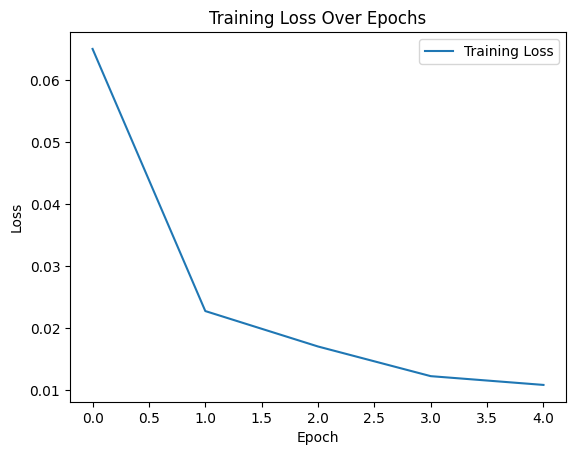

In [20]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
# Prediction of the next price
model.add(Dense(units=1))  

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# Track parameters explicitly if desired
experiment_params = {
    "sequence_length": sequence_length,
    "units": 50,
    "dropout_rate": 0.2,
    "epochs": 5,
    "batch_size": 32
}

# Start MLflow experiment run
with mlflow.start_run():
    # Log custom parameters
    for param, value in experiment_params.items():
        mlflow.log_param(param, value)

    # Train the model
    history = model.fit(X_train, y_train, epochs=experiment_params["epochs"], batch_size=experiment_params["batch_size"])

    # Log the trained model
    mlflow.keras.log_model(model, "lstm_model")

    # log custom metrics like final training loss
    final_loss = history.history["loss"][-1]
    mlflow.log_metric("final_training_loss", final_loss)

    # Plot training loss and log it
    import matplotlib.pyplot as plt
    plt.plot(history.history["loss"], label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("training_loss_plot.png")
    mlflow.log_artifact("training_loss_plot.png", "training_loss_plot")

# Stop the Spark session
spark.stop()


### Obtaining evaluation criterias

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

#Split the last 20% of data as a test set
split = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split], scaled_data[split:]

# Create test sequences
X_test, y_test = [], []
for i in range(sequence_length, len(test_data)):
    X_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test set
predicted_prices = model.predict(X_test)

# Inverse transform to get predictions back to original price scale
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the metrics
mae = mean_absolute_error(y_test_actual, predicted_prices)
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_prices))
mape = mean_absolute_percentage_error(y_test_actual, predicted_prices)

# Log metrics in MLflow
with mlflow.start_run():
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAPE", mape)

    print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
MAE: 2.199912459762008, RMSE: 2.668047902963845, MAPE: 0.02071106062086207


### Export model to h5 format 

#### Only if the evaluation criteria are good enough

In [22]:

# threshold criteria
mae_threshold = 4  
rmse_threshold = 4

# Save the model only if it meets the criteria
if mae <= mae_threshold and rmse <= rmse_threshold:
    model.save("lstm_stock_predictor.h5")
    print("Model meets criteria and has been saved.")
else:
    print("Model does not meet criteria and was not saved.")

Model meets criteria and has been saved.
